**Concept:**
+ Create strain data resembling X-ray measurements on 2D detector. The variance is mostly normally distributed, due to uncertainty in peak position, but with some noise from a student T distribution (fatter tails - more extreme noise) reflecting poor sampling from grains.
+ The data is synthetic so we know what the stress was that generated the simulated strains
+ Simple OLS is used for comparison (fast, simple)
+ There are three bayesian modelling approaches:
    + OLS (normal likelihood function) that is sensitive to outliers
    + Student T likelihood function which should allow for some points to be far from the mean without undue influence
    + Custom likelihood function as a mixture of two likelihoods, one for the main strain-generating function, and one for outliers. This will identify likely outliers.


# Imports and Functions

In [58]:
#import the maths/stats modules
import numpy as np
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import pandas,os

#import mcmc model
import pymc3 as pm
import arviz as az
# tell arviz to load all the data rather than do lazy loading
# I think this reduces file access issues later 
az.rcParams['data.load'] = 'eager'

#import plotting modules and do some settings
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('white')
seaborn.set_context('notebook')

import warnings
warnings.filterwarnings('ignore')   # There is a warning about a deprecated function. 
                                    # It's in theano so there is nothing we can do about it

In [57]:
def calculate_directions(data):
    '''Calculate the scattering vector components for a simple transmission geometry, high E, setup.
    
    Parameters
    ----------
    gamma : array-like
        The angle around the detector.
    '''
    data = data.copy()
    data['h1'] = np.cos(data['gamma'])
    data['h2'] = np.sin(data['gamma'])
    data['h3'] = np.zeros(data.shape[0]) #nearly zero for high energy (low 2theta)
    return data

def calculate_stress_factors(data,E,v,components='11,22,12'):
    '''Calculate the stress factor for a measurement direction. 
    
    Parameters
    ----------
    data : pandas dataframe containing columns 'h1','h2','h3' 
        (3 x m) array of direction vector components for scattering vector  
    E: float
         Young's modulus of the material (isotropic)
    v: float
        Poisson's ratio for the material (isotropic)
    components: string
        Which tensor components do you want in 2 digit, comma-separated string
    '''        
    
    #this is a cheap copy, only creating new indices, etc - no bulk copying of the underlying data
    data = data.copy()
    
    comps = [[int(c) for c in comp] for comp in components.split(',')]
    
    for row,(i,j) in enumerate(comps):
        hi,hj = data['h{}'.format(i)],data['h{}'.format(j)]
        label = 'p{}{}'.format(i,j)
        data[label] = (1+v)*hi*hj 
        if i==j:
            data[label] -= v
        else:
            data[label] *= 2
        data[label]*=(1./E)
        
    return data

def generate_stress(data,groupby,label,function,**kwargs):
    data = data.copy()
    for name,group in data.groupby(groupby)
        data.loc[name,label] = function(**kwargs)
    return data

def generate_strain(data):
    data=data.copy()
    p = data.filter(regex='^p[1-3]{2,2}$')
    s = data.filter(regex='^s[1-3]{2,2}$')
    data['strain'] = np.einsum("ij,ij->i", p, s)
    return data

def create_true_dataset(number_of_locations,E,v,stress):
    number_of_angles = 360
    gamma = np.arange(number_of_angles)*2*np.pi/number_of_angles
    true = np.vstack([np.repeat(np.arange(1,number_of_locations+1),number_of_angles), #give each location an id number
                      np.tile(np.arange(number_of_angles),number_of_locations)])   #give each angle an id number
    true = pandas.DataFrame(true.T,columns=['location','measurement']) #create the dataframe

    true['gamma'] = np.tile(gamma,number_of_locations)
    true = true.set_index(['location','measurement'])

    true = calculate_directions(true)
    true = calculate_stress_factors(true,E,v,components=','.join(stress.keys()))
    
    for key,value in stress.items():
        true = generate_stress(true,'location','s{}'.format(key),np.random.normal,loc=value['mean'],scale=value['std']) #set scale to zero for no noise

    true = generate_strain(true)
    
    return true

def create_measurements(data,strain_err_range=(50e-6,150e-6),measurements_per_location=24):
    step = int(round(data.shape[0]/(len(data.groupby('location'))*measurements_per_location)))
    
    data = data.loc[::step,~data.columns.str.contains('^[h,s][0-3]{1,2}$')].copy()
    
    #this is the uncertainty arising from peak fitting i.e. size and width of peak gives range of probable centres
    #this value is the actual std dev and would be estimated from the peak during fitting
    data['strain unc'] = np.random.uniform(low=strain_err_range[0],high=strain_err_range[1],size=data.shape[0])
    #this is the actual offset, drawn from a distribution with mean of zero and width given by the uncertainty
    data['strain'] += np.random.normal(loc=0,scale=data['strain unc'])
    
    #add on noise from grain size sampling. This is hidden to us normally. A nice, big peak with low error may still be off due to 
    #bad sampling
    #data['strain'] += st.t(df=2,scale=20).rvs(size=data.shape[0])
    
    return data

## Make the data

The data is generated as N measurements on a nominally uniform surface. The stress for each location is drawn from a normal distribtion reflecting variations in stress state. The 'true' dataset contains the actual strain calculated from the stress tensor for each location. The simulated data is generated by adding normally distributed noise reflecting the fitting precision of the diffraction peaks. The sigma of the distribution has a range which is then returned as the uncertainty on peak position. The actual shift of the point if then drawn from a normal distribution with a mean of zero and sigma equal to the uncertainty.

In this case the following is true:
+ There is only a single location with 12 peaks measured around the detector angle.
+ Only one in-plane stress component is non-zero. 
+ All measurements have a precision of 100 microstrain and the actual shift is therefore normally distributed and most will lie within 300 microstrain of the true signal.
+ We then add noise drawn from a studentT with a very low degree of freedom (fat tails). The scale is 250 microstrain so a few points should be quite far from the expected strain.

Note that nothing is saved yet.

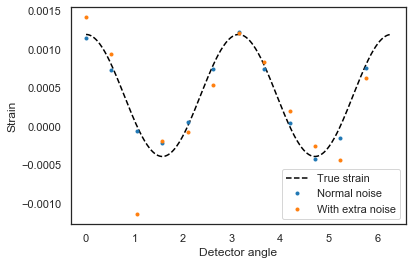

In [60]:
#No noise at all, correct strain given the stress provided
true = create_true_dataset(number_of_locations=1,E=210000,v=0.33,
                           #for each stress component (keys of dictionary) we give a mean stress and standard dev
                           stress={'11':{'mean':250,'std':0},'22':{'mean':0,'std':0},'12':{'mean':0,'std':0}})

#this data has normally distributed noise as would be found from peak fit uncertainty
data = create_measurements(true,strain_err_range=(100*1e-6,100*1e-6),measurements_per_location=12)

f,ax = plt.subplots()
ax.plot(true['gamma'],true['strain'],'k--',label='True strain')
ax.plot(data['gamma'],data['strain'],'.',label='Normal noise')

#add high noise from student t (wide tails)
data['strain'] += st.t(df=2,scale=250/1e6).rvs(size=data.shape[0])
ax.plot(data['gamma'],data['strain'],'.',label='With extra noise')
ax.set_xlabel('Detector angle')
ax.set_ylabel('Strain')
ax.legend()

Save the data if you are happy with it.

In [92]:
true.to_hdf('fitting_grain_noise.h5','true')
data.to_hdf('fitting_grain_noise.h5','simulation')

Load the currently saved simulated dataset and plot it.

Text(0, 0.5, 'Strain, $\\epsilon$')

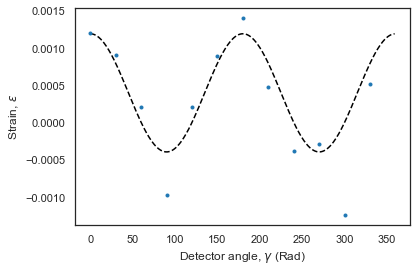

In [20]:

true = pandas.read_hdf('fitting_grain_noise.h5','true')
data = pandas.read_hdf('fitting_grain_noise.h5','simulation')

f,ax = plt.subplots()
ax.plot(np.rad2deg(true['gamma']),true['strain'],'k--', label = 'True Strain')
ax.plot(np.rad2deg(data['gamma']),data['strain'],'.', label = 'Strain Measurements')

ax.set_xlabel('Detector angle, $\gamma$ (Rad)')
ax.set_ylabel('Strain, $\epsilon$')


In this case we have at least 2 data points that look like outliers at a glance.

# Fitting the models

## Least squares

In [137]:
#Make a copy of the data to save the fits in.
lsq_fit = pandas.read_hdf('fitting_grain_noise.h5','simulation')

#get stress factors from columns
p = data.filter(regex='^[p][1-3]{2,2}$')
#create a fitting model by supplying formula string
f = 'strain ~ {:} -1'.format(' + '.join(p.columns))

# The weights correct for experimental precision - as far as I can tell it's meant to be reciprocal of uncertainty
mod = smf.wls(formula='strain ~ p11 + p22 + p12 -1', data=lsq_fit, weights=1./lsq_fit['strain unc'])

fit = mod.fit()

#insert the fitted strains in a new column
lsq_fit['fitted_strain'] = fit.predict() #predict gives the strain for the fitted parameters

#now calculate the upper,lower confidence limits and add them in the same way
prstd, iv_l, iv_u = wls_prediction_std(fit)
lsq_fit['fitted_strain_cll'] = iv_l
lsq_fit['fitted_strain_clu'] = iv_u

#save the results in the dataframe. Every row has the same number but that's fine - pandas is very efficient with duplicates
for i,column in enumerate(p.columns):
    label = 's{:}'.format(column.strip('p')) 
    lsq_fit[label] = fit.params[i] # add the refined stress
    lsq_fit[label+'_unc'] = fit.bse[i] # add the apparent uncertainty
    
lsq_fit['method'] = 'lsq'

lsq_fit.to_hdf('fitting_grain_noise.h5','lsq')

## OLS (Bayesian implementation)

In [56]:
bay_fit = pandas.read_hdf('fitting_grain_noise.h5','simulation')

#standardise the data - mainly for the outlier detection later, also seems much faster (?!)
emean = bay_fit['strain'].mean()
twoestd = 2*bay_fit['strain'].std()
bay_fit['strain'] = (bay_fit['strain']-emean)/twoestd
bay_fit['strain unc'] = bay_fit['strain unc']/twoestd

#extract the stress factors of the form pij for i,j = 1 to 3
p = bay_fit.filter(regex='^[p][1-3]{2,2}$')

with pm.Model(): #any distributions created below are automatically added to this model 

    #the stress is the sum of all the components so we create each distribution one at a time
    mu = []
    for column in p.columns: #create one at a time 
        label = 's{:}'.format(column.strip('p')) #i.e. factor p11 becomes stress s11
        stress = pm.Normal(label, 
                           mu = 0, 
                           sigma=1e5 #very weak prior 
                           ) 
        mu.append(stress*p[column].values)
    #we can just sum the distributions, also standardise like the data
    mu = (sum(mu)-emean)/twoestd
    #this distribution reflects expected noise from sampling too few grains
#         grain_noise = pm.HalfNormal('sigma', sigma = 0.1)

    sigma =  bay_fit['strain unc'] #+ grain_noise

    likelihood = pm.Normal('strain', mu=mu, sigma=sigma, observed=bay_fit['strain'].values)

    #do the inference 
    trace = pm.sample(draws=500, tune=2000, cores=4, chains=4)
    #sample data as though prior is correct
    prior = pm.sample_prior_predictive()
    #samples data with corrected prior distribution
    posterior_predictive = pm.sample_posterior_predictive(trace)

#in order to save the traces and everything we create an inference object using arviz
bay_trace = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=posterior_predictive)


# save the predicted strain + credible interval to the frame
bay_fit['fitted_strain'] = posterior_predictive['strain'].mean(axis=0)
#add the 95% credible interval i.e. range that contains 95% of possible values for each location
bay_fit['fitted_strain_cll'] = np.percentile(posterior_predictive['strain'],2.5,axis=0)
bay_fit['fitted_strain_clu'] = np.percentile(posterior_predictive['strain'],97.5,axis=0)

# save the stress outcome
for name in trace.varnames:
    bay_fit[name] = trace[name].mean(axis=0)
    bay_fit['{:}_unc'.format(name)] = trace[name].std(axis=0)

#for easy checking later
bay_fit['method'] = 'bayesian'

#save the data summary and trace
bay_fit.to_hdf('fitting_grain_noise.h5','bayasian')
bay_trace.to_netcdf('fitting_grain_noise_bayesian.cdf')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s12, s22, s11]
100%|█████████████████████████████████████████| 2000/2000 [00:01<00:00, 1186.50it/s]


'fitting_grain_noise_bayesian.cdf'

### Diagnostics

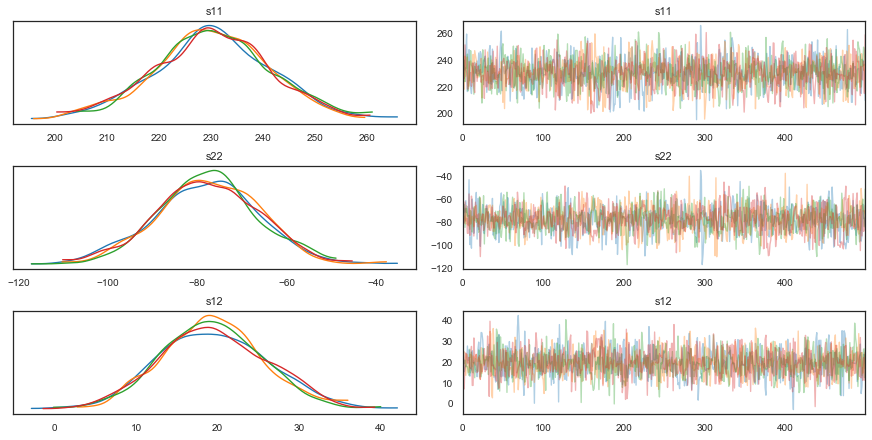

In [54]:
bay_trace = az.from_netcdf('fitting_grain_noise_bayesian.cdf')
pm.plot_trace(bay_trace);

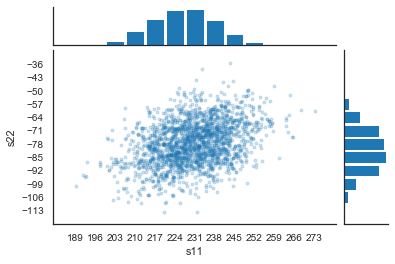

In [57]:
bay_trace = az.from_netcdf('fitting_grain_noise_bayesian.cdf')
az.plot_pair(bay_trace,var_names=['s11','s22'],
                       kind="scatter", scatter_kwargs={"alpha": 0.2},
                       marginals=True,marginal_kwargs={"kind":"hist"},
            textsize=10);

seaborn.despine()

## Robust bayesian

Use student-t distribution on liklihood function

In [58]:
rob_fit = pandas.read_hdf('fitting_grain_noise.h5','simulation')

#standardise the data - mainly for the outlier detection later, also seems much faster (?!)
emean = rob_fit['strain'].mean()
twoestd = 2*rob_fit['strain'].std()
rob_fit['strain'] = (rob_fit['strain']-emean)/twoestd
rob_fit['strain unc'] = rob_fit['strain unc']/twoestd

#extract the stress factors of the form pij for i,j = 1 to 3
p = rob_fit.filter(regex='^[p][1-3]{2,2}$')

with pm.Model(): #any distributions created below are automatically added to this model 

    #the stress is the sum of all the components so we create each distribution one at a time
    mu = []
    for column in p.columns: #create one at a time 
        label = 's{:}'.format(column.strip('p')) #i.e. factor p11 becomes stress s11
        stress = pm.Normal(label, 
                           mu = 0, 
                           sigma = 1e5 #very weak prior
                           ) 
        mu.append(stress*p[column].values)
    #we can just sum the distributions, also standardise like the data
    mu = (sum(mu)-emean)/twoestd

    #this distribution reflects expected noise from sampling too few grains
#         grain_noise = pm.HalfNormal('sigma', sigma = 0.1)

    sigma =  rob_fit['strain unc'] #+ grain_noise

    # define prior for StudentT degrees of freedom
    # InverseGamma has nice properties: it's continuous and has support x ∈ (0, inf)
    nu = pm.InverseGamma("nu", alpha=1, beta=1)

    likelihood = pm.StudentT('strain', mu=mu, sigma=sigma, nu=nu,observed=rob_fit['strain'].values)

    #do the inference 
    trace = pm.sample(draws=500, tune=5000, cores=4, chains=4)
    #sample data as though prior is correct
    prior = pm.sample_prior_predictive()
    #samples data with corrected prior distribution
    posterior_predictive = pm.sample_posterior_predictive(trace)

#in order to save the traces and everything we create an inference object using arviz
rob_trace = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=posterior_predictive)


# save the predicted strain + credible interval to the frame
rob_fit['fitted_strain'] = posterior_predictive['strain'].mean(axis=0)
#add the 95% credible interval i.e. range that contains 95% of possible values for each location
rob_fit['fitted_strain_cll'] = np.percentile(posterior_predictive['strain'],2.5,axis=0)
rob_fit['fitted_strain_clu'] = np.percentile(posterior_predictive['strain'],97.5,axis=0)

# save the stress outcome
for name in trace.varnames:
    rob_fit[name] = trace[name].mean(axis=0)
    rob_fit['{:}_unc'.format(name)] = trace[name].std(axis=0)
    
rob_fit['method'] = 'robust'

rob_fit.to_hdf('fitting_grain_noise.h5','robust')
rob_trace.to_netcdf('fitting_grain_noise_robust.cdf')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, s12, s22, s11]
Sampling 4 chains, 0 divergences: 100%|██| 22000/22000 [00:19<00:00, 1104.48draws/s]
The acceptance probability does not match the target. It is 0.699956709616862, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
100%|█████████████████████████████████████████| 2000/2000 [00:01<00:00, 1042.81it/s]


'fitting_grain_noise_robust.cdf'

### Diagnostics

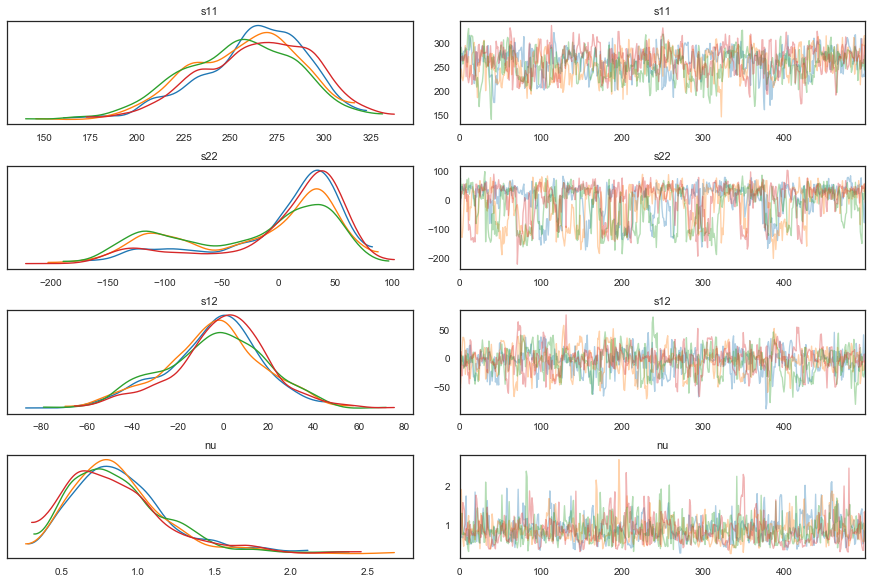

In [59]:
rob_trace = az.from_netcdf('fitting_grain_noise_robust.cdf')
az.plot_trace(rob_trace);

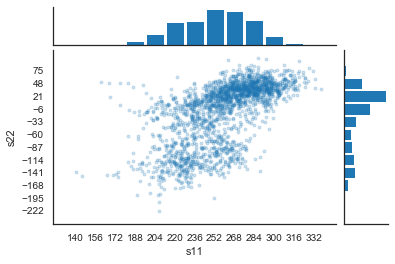

In [60]:
rob_trace = az.from_netcdf('fitting_grain_noise_robust.cdf')
az.plot_pair(rob_trace,var_names=['s11','s22'],
                       kind="scatter", scatter_kwargs={"alpha": 0.2},
                       marginals=True,marginal_kwargs={"kind":"hist"},
                    textsize=10);
seaborn.despine()

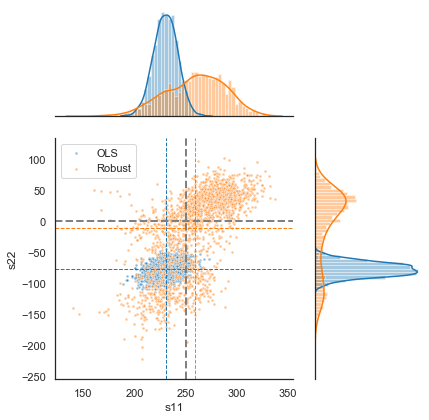

In [68]:
traces = [
          az.from_netcdf('fitting_grain_noise_bayesian.cdf').posterior.to_dataframe().reset_index(),
          az.from_netcdf('fitting_grain_noise_robust.cdf').posterior.to_dataframe().reset_index()
]
descriptions = ['OLS','Robust']

fts = ["s11", "s22"]
df_trc = pandas.concat([trace[fts] for trace in traces], sort=False)

df_trc["model"] = pandas.Categorical(
    np.hstack([[d]*len(trace) for d,trace in zip(descriptions,traces)]),
    categories=descriptions,
    ordered=True
)

gd = seaborn.JointGrid(x="s11", y="s22", data=df_trc, height=6,ratio=2)

#these are used to create consistant histogram bins for all distributions
_, x_bin_edges = np.histogram(df_trc["s11"], 60)
_, y_bin_edges = np.histogram(df_trc["s22"], 60)

kde_kws = dict(zorder=2, n_levels=5, cmap="gray_r")
dist_kws = dict(kde_kws=dict(cut=1), axlabel=False)

for i,(idx,grp) in enumerate(df_trc.groupby('model')):
    ax = seaborn.scatterplot(grp["s11"], grp["s22"], ax=gd.ax_joint, alpha=0.5, s=8, label=idx)
    #seaborn.kdeplot(grp["s11"], grp["s22"], ax=gd.ax_joint, **kde_kws)
    seaborn.distplot(grp["s11"], **dist_kws, bins=x_bin_edges, ax=gd.ax_marg_x)
    seaborn.distplot(grp["s22"], **dist_kws, vertical=True, bins=y_bin_edges, ax=gd.ax_marg_y)
    means = grp.mean()
    gd.ax_joint.axvline(means['s11'],color='C%i'%i,lw=1,linestyle='--')
    gd.ax_joint.axhline(means['s22'],color='C%i'%i,lw=1,linestyle='--')
    
gd.ax_joint.legend();
true = pandas.read_hdf('fitting_grain_noise.h5','true')
trues11 = true['s11'].iloc[0] #first entry inthe frame
trues22 = true['s22'].iloc[0]
#gd.ax_joint.plot(trues11,trues22,'ks',ms=5)
gd.ax_joint.axvline(trues11,color='0.5',lw=2,linestyle='--')
gd.ax_joint.axhline(trues22,color='0.5',lw=2,linestyle='--');


The OLS (bayesian version) is both wrong but also much more confident that it is correct in the marginals for both stress components. The robust fitting does a better job of ignoring the outliers but there is a second centre of samples closer to the OLS solution (only really for $\sigma_{22}$). I guess that is when the degrees of freedom of the student T are higher and the tails get thinner. The variance of the robust fitting looks more believable to me - we can't know that the outlier really is right or wrong. 

# Outlier detection

The likelihood is evaluated over a mixture of two likelihoods, one for 'inliers', one for 'outliers'. A Bernoulli distribution is used to randomly assign datapoints in N to either the inlier or outlier groups, and we sample the model as usual to infer robust model parameters and inlier / outlier flags:

$$
\mathcal{logL} = \sum_{i}^{i=N} log \left[ \frac{(1 - B_{i})}{\sqrt{2 \pi \sigma_{in}^{2}}} exp \left( - \frac{(x_{i} - \mu_{in})^{2}}{2\sigma_{in}^{2}} \right) \right] + \sum_{i}^{i=N} log \left[ \frac{B_{i}}{\sqrt{2 \pi (\sigma_{in}^{2} + \sigma_{out}^{2})}} exp \left( - \frac{(x_{i}- \mu_{out})^{2}}{2(\sigma_{in}^{2} + \sigma_{out}^{2})} \right) \right]
$$

where:  
+ $B_{i}$ is Bernoulli-distibuted $B_{i} \in \{0_{(inlier)},1_{(outlier)}\}$
+ $\mu_{in} = \beta^{T} \vec{x}_{i}$ as before for inliers, where $\beta$ = $\{1, \beta_{j \in X_{j}}\}$  <--- linear coefs in 
$X_{j}$, in this case `1 + x`
+ $\sigma_{in}$ = noise term <--- in this case we set this to an _unpooled_ $\sigma_{i}$: the measured error `sigma_y` for each datapoint
+ $\mu_{out}$ <--- is a random _pooled_ variable for outliers
+ $\sigma_{out}$ = additional noise term <--- is a random _unpooled_ variable for outliers

#### Model origin

+ The likelihood evaluation is essentially a copy of eqn 17 in "Data analysis recipes: Fitting a model to data" - [Hogg 2010](http://arxiv.org/abs/1008.4686))
+ More specifically, this implementation is drawn from "GLM-robust-with-outlier-detection" [pymc3](https://docs.pymc.io/notebooks/GLM-robust-with-outlier-detection.html)

#### Standardization

It's common practice to standardize the input values to a linear model, because this leads to coefficients 
sitting in the same range and being more directly comparable. e.g. Gelman notes this in a 2007 
paper: http://www.stat.columbia.edu/~gelman/research/published/standardizing7.pdf.

So, following Gelman's paper above, we'll divide by 2 s.d. here


**Additional note** on scaling the output feature `strain` and measurement error `strain unc`:
+ This is unconventional - typically you wouldn't scale an output feature
+ However, in the Hogg model we fit a custom two-part likelihood function of Normals which encourages 
a globally minimised log-loss by allowing outliers to fit to their own Normal distribution. This 
outlier distribution is specified using a stdev stated as an offset `sigma_out` from `obs_sigma`
+ This offset value has the effect of requiring `obs_sigma` to be restated in the same scale as the stdev of `strain`

In [3]:
out_fit = pandas.read_hdf('fitting_grain_noise.h5','simulation')

#standardise the data - mainly for the outlier detection later, also seems much faster (?!)
emean = out_fit['strain'].mean()
twoestd = 2*out_fit['strain'].std()
out_fit['strain'] = (out_fit['strain']-emean)/twoestd
out_fit['strain unc'] = out_fit['strain unc']/twoestd

#extract the stress factors of the form pij for i,j = 1 to 3
p = out_fit.filter(regex='^[p][1-3]{2,2}$')

with pm.Model(): #any distributions created below are automatically added to this model 
    
    obs_strain = pm.Data("obs_strain", out_fit['strain']) # (n, )
    obs_sigma = pm.Data("obs_sigma", out_fit['strain unc'])  # (n, )
    
    #the stress is the sum of all the components so we create each distribution one at a time
    mu_in = []
    for column in p.columns: #create one at a time 
        label = 's{:}'.format(column.strip('p')) #i.e. factor p11 becomes stress s11
        stress = pm.Normal(label, mu= 0, sigma=100, testval=pm.floatX(0.0)) 
        mu_in.append(stress*p[column].values)
    #we can just sum the distributions, also standardise like the data
    mu_in = (sum(mu_in)-emean)/twoestd
    
    #weakly informative mean for outliers
    mu_out = pm.Normal("mu_out", mu=0, sigma=10, testval=pm.floatX(0.0))  # (1, )
    # very weakly informative prior for additional variance for outliers
    sigma_out = pm.HalfNormal("sigma_out", sigma=10, testval=pm.floatX(1.0))  # (1, )

    # create in/outlier distributions to get a logp evaluated on the observed y
    # this is not strictly a pymc3 likelihood, but behaves like one when we
    # evaluate it within a Potential (which is minimised)
    inlier_logp = pm.Normal.dist(mu=mu_in, sigma=obs_sigma).logp(obs_strain)

    outlier_logp = pm.Normal.dist(mu=mu_out, sigma=obs_sigma + sigma_out).logp(obs_strain)

    # frac_outliers only needs to span [0, .5]
    # testval for is_outlier initialised in order to create class asymmetry
    frac_outliers = pm.Uniform("frac_outliers", lower=0.0, upper=0.5)
    is_outlier = pm.Bernoulli(
        "is_outlier",
        p=frac_outliers,
        shape=obs_strain.eval().shape[0],
        testval=(np.random.rand(obs_strain.eval().shape[0]) < 0.4) * 1,
    )  # (n, )

    # non-sampled Potential evaluates the Normal.dist.logp's
    potential = pm.Potential("obs",((1 - is_outlier) * inlier_logp).sum() + (is_outlier * outlier_logp).sum())

    # I changed the processor here - advi dies when I run it.
    trace = pm.sample(tune=10000,draws=500,chains=4,cores=4,init="jitter+adapt_diag",nuts={"target_accept": 0.9})
    
    #sample data as though prior is correct
    prior = pm.sample_prior_predictive()
    #samples data with corrected prior distribution
    posterior_predictive = pm.sample_posterior_predictive(trace)

#in order to save the traces and everything we create an inference object using arviz
out_trace = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=posterior_predictive,
                         coords={'measurement':out_fit.reset_index()['measurement']},
                         dims={"is_outlier": ["measurement"]})


#Not sure how to do this part!
# # save the predicted strain + credible interval to the frame
# out_fit['fitted_strain'] = posterior_predictive['strain'].mean(axis=0)
# #add the 95% credible interval i.e. range that contains 95% of possible values for each location
# out_fit['fitted_strain_cll'] = np.percentile(posterior_predictive['strain'],2.5,axis=0)
# out_fit['fitted_strain_clu'] = np.percentile(posterior_predictive['strain'],97.5,axis=0)

# save the stress outcome
for name in trace.varnames:
    out_fit[name] = trace[name].mean(axis=0)
    out_fit['{:}_unc'.format(name)] = trace[name].std(axis=0)
    
out_fit['method'] = 'outlier'

out_fit.to_hdf('fitting_grain_noise.h5','outlier')
out_trace.to_netcdf('fitting_grain_noise_outlier.cdf')

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [frac_outliers, sigma_out, mu_out, s12, s22, s11]
>BinaryGibbsMetropolis: [is_outlier]
Sampling 4 chains, 0 divergences: 100%|███| 42000/42000 [00:53<00:00, 782.35draws/s]
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|████████████████████████████████████████| 2000/2000 [00:00<00:00, 19098.57it/s]


'fitting_grain_noise_outlier.cdf'

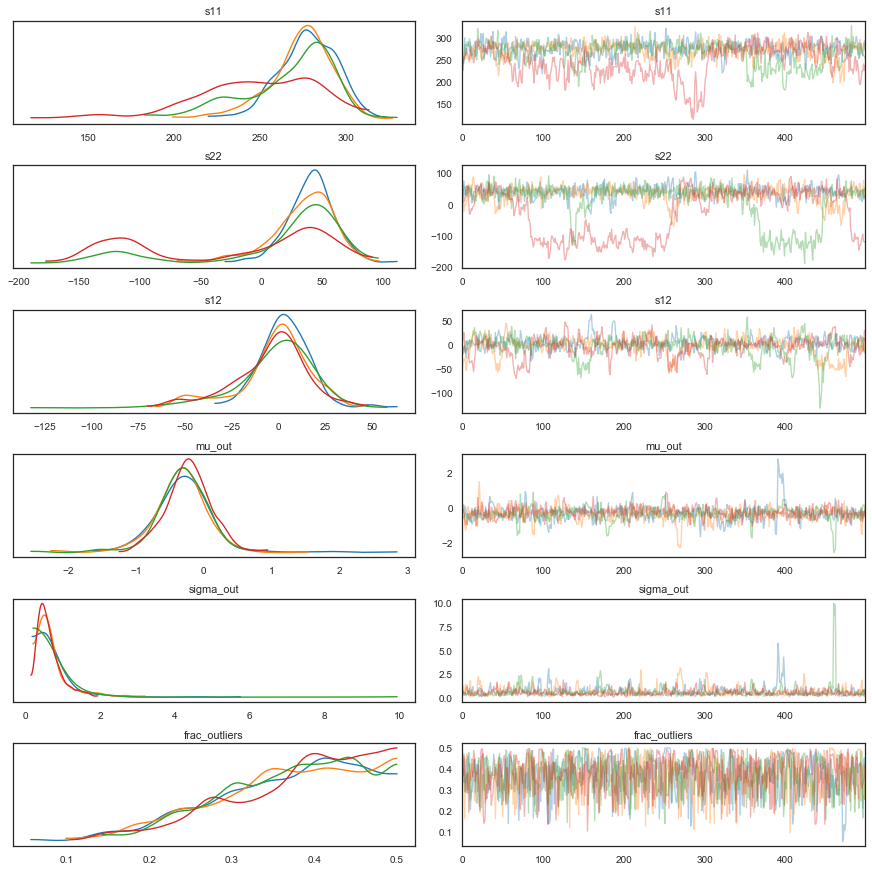

In [71]:
out_trace = az.from_netcdf('fitting_grain_noise_outlier.cdf')
az.plot_trace(out_trace,var_names=['s11','s22','s12','mu_out','sigma_out','frac_outliers']);

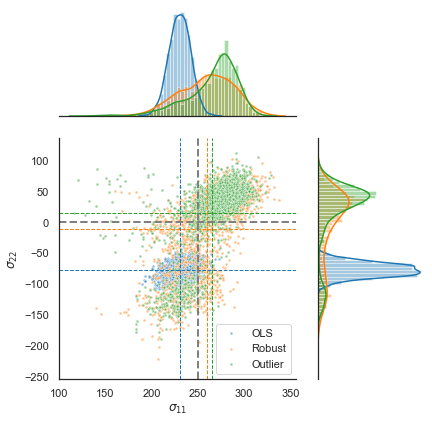

In [72]:
traces = [
          az.from_netcdf('fitting_grain_noise_bayesian.cdf').posterior.to_dataframe().reset_index(),
          az.from_netcdf('fitting_grain_noise_robust.cdf').posterior.to_dataframe().reset_index(),
          #some brutal cleaning up needed - I'm sure this is fixable earlier but hack it for now
          az.from_netcdf('fitting_grain_noise_outlier.cdf').posterior.to_dataframe().groupby(['chain','draw']).first().reset_index()
]
descriptions = ['OLS','Robust','Outlier']

fts = ["s11", "s22"]
df_trc = pandas.concat([trace[fts] for trace in traces], sort=False)

df_trc["model"] = pandas.Categorical(
    np.hstack([[d]*len(trace) for d,trace in zip(descriptions,traces)]),
    categories=descriptions,
    ordered=True
)

gd = seaborn.JointGrid(x="s11", y="s22", data=df_trc, height=6,ratio=2)

#these are used to create consistant histogram bins for all distributions
_, x_bin_edges = np.histogram(df_trc["s11"], 60)
_, y_bin_edges = np.histogram(df_trc["s22"], 60)

kde_kws = dict(zorder=2, n_levels=5, cmap="gray_r")
dist_kws = dict(kde_kws=dict(cut=1), axlabel=False)

for i,(idx,grp) in enumerate(df_trc.groupby('model')):
    ax = seaborn.scatterplot(grp["s11"], grp["s22"], ax=gd.ax_joint, alpha=0.5, s=8, label=idx)
    #seaborn.kdeplot(grp["s11"], grp["s22"], ax=gd.ax_joint, **kde_kws)
    seaborn.distplot(grp["s11"], **dist_kws, bins=x_bin_edges, ax=gd.ax_marg_x)
    seaborn.distplot(grp["s22"], **dist_kws, vertical=True, bins=y_bin_edges, ax=gd.ax_marg_y)
    means = grp.mean()
    gd.ax_joint.axvline(means['s11'],color='C%i'%i,lw=1,linestyle='--')
    gd.ax_joint.axhline(means['s22'],color='C%i'%i,lw=1,linestyle='--')
    
gd.ax_joint.legend();
true = pandas.read_hdf('fitting_grain_noise.h5','true')
trues11 = true['s11'].iloc[0] #first entry inthe frame
trues22 = true['s22'].iloc[0]
#gd.ax_joint.plot(trues11,trues22,'ks',ms=5)
gd.ax_joint.axvline(trues11,color='0.5',lw=2,linestyle='--')
gd.ax_joint.axhline(trues22,color='0.5',lw=2,linestyle='--')

gd.ax_joint.set_xlabel('$\sigma_{11}$') #renders as latex with proper symbol
gd.ax_joint.set_ylabel('$\sigma_{22}$');
#I'm resorting to legends here -not happy but the alternative is not worth the effort.

Both the robust and outlier detection result in bimodel distributions. I guess depending on if one or two outlier end up contributing as a function of the fit parameters. The means of the distributions for both are closer to the true stress than ordinary least squares (bayesian implementation) while the variance is more believable (wider).The inlier marginal distribution is a bit more narrow for the outlier detection but there isn't much in it. It slower and more complex to implement so maybe not worth it?

### Check on outlier identification

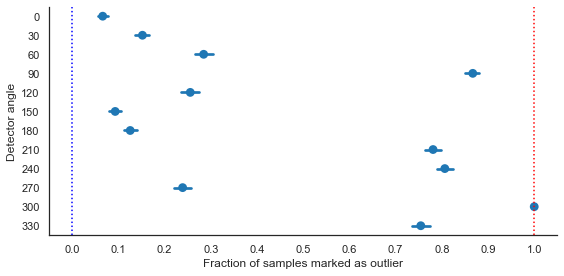

In [54]:
#display(pm.trace_to_dataframe(trace).head())
data = pandas.read_hdf('fitting_grain_noise.h5','simulation')
trc_hogg = az.from_netcdf('fitting_grain_noise_outlier.cdf').posterior

df_outlier_results = trc_hogg.to_dataframe().reset_index()[['measurement','is_outlier']]
df_outlier_results['measurement'] = df_outlier_results['measurement'].astype('category')

gd = seaborn.catplot(
    y="measurement",
    x="is_outlier",
    data=df_outlier_results,
    kind="point",
    join=False,
    height=4,
    aspect=2,
)
gd.fig.axes[0].set(xlim=(-0.05, 1.05), xticks=np.arange(0, 1.1, 0.1))
gd.fig.axes[0].axvline(x=0, color="b", linestyle=":")
gd.fig.axes[0].axvline(x=1, color="r", linestyle=":")
gd.fig.axes[0].yaxis.grid(True, linestyle="-", which="major", color="w", alpha=0.4)
gd.fig.axes[0].set_xlabel('Fraction of samples marked as outlier')
gd.fig.axes[0].set_ylabel('Detector angle');
    

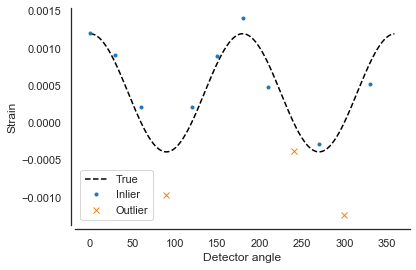

In [49]:
data = pandas.read_hdf('fitting_grain_noise.h5','simulation')
trc = az.from_netcdf('fitting_grain_noise_outlier.cdf').posterior#.to_dataframe().groupby('measurement')

#more issues with loading trace from netcdf - different dimensions to full trace direct from pymc3. Need to coerce shape.
is_outlier = np.reshape(trc['is_outlier'].values,(-1,len(data)))

#if classified as outlier >80% of the time, call it an outlier. Arbitrary but reasonable.
cutoff = 0.2
data["classed_as_outlier"] = np.quantile(is_outlier, cutoff, axis=0) == 1

f,ax = plt.subplots()
#plot true strain
ax.plot(np.rad2deg(true['gamma']),
        true['strain'],'k--',label='True')
#plot the inliers
ax.plot(np.rad2deg(data['gamma'][~data["classed_as_outlier"]]),
        data['strain'][~data["classed_as_outlier"]],'.',label='Inlier') #~ means 'if not'
#plot the outliers
ax.plot(np.rad2deg(data['gamma'][data["classed_as_outlier"]]),
        data['strain'][data["classed_as_outlier"]],'x',label='Outlier') 

ax.set_xlabel('Detector angle')
ax.set_ylabel('Strain')
ax.legend()

seaborn.despine(offset=4)